# Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
# Initialize PySpark
APP_NAME = "Debugging Prediction Problems"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


# Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [2]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

# Creating Objects from CSV using `pyspark.RDD.map`

Using a function with a map operation to create objects (dicts) as records...

In [3]:
# Turn the CSV lines into objects
def csv_to_record(line):
  parts = line.split(",")
  record = {
    "name": parts[0],
    "company": parts[1],
    "title": parts[2]
  }
  return record

# Apply the function to every record
records = csv_lines.map(csv_to_record)

# Inspect the first item in the dataset
records.first()

{'name': 'Russell Jurney', 'company': 'Relato', 'title': 'CEO'}

# `pyspark.RDD.groupBy`

Using the groupBy operator to count the number of jobs per person...

In [5]:
# Group the records by the name of the person
grouped_records = records.groupBy(lambda x: x["name"])

# Show the first group
print(grouped_records.first())

# Count the groups
job_counts = grouped_records.map(
  lambda x: {
    "name": x[0],
    "job_count": len(x[1])
  }
)

job_counts.collect()

('Florian Liebert', <pyspark.resultiterable.ResultIterable object at 0x7f8a6020f438>)


[{'name': 'Florian Liebert', 'job_count': 1},
 {'name': 'Russell Jurney', 'job_count': 2},
 {'name': 'Don Brown', 'job_count': 1},
 {'name': 'Steve Jobs', 'job_count': 1},
 {'name': 'Donald Trump', 'job_count': 1}]

## Exercises

1. Use `pyspark.RDD.groupBy` to group executives by job title, then prepare records with the job title and the count of the number of executives with that job.

# Map vs FlatMap

We need to understand the difference between the map and flatmap operators. Map groups items per-record, while flatMap creates a single large group of items.

In [6]:
# Compute a relation of words by line
words_by_line = csv_lines\
  .map(lambda line: line.split(","))

words_by_line.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

In [7]:
# Compute a relation of words
flattened_words = csv_lines\
  .map(lambda line: line.split(","))\
  .flatMap(lambda x: x)
flattened_words.collect()

['Russell Jurney',
 'Relato',
 'CEO',
 'Florian Liebert',
 'Mesosphere',
 'CEO',
 'Don Brown',
 'Rocana',
 'CIO',
 'Steve Jobs',
 'Apple',
 'CEO',
 'Donald Trump',
 'The Trump Organization',
 'CEO',
 'Russell Jurney',
 'Data Syndrome',
 'Principal Consultant']

In [8]:
lengths = flattened_words.map(lambda x: len(x))
lengths.collect()

[14, 6, 3, 15, 10, 3, 9, 6, 3, 10, 5, 3, 12, 22, 3, 14, 13, 20]

In [9]:
lengths.sum() / lengths.count()

9.5

# Creating Rows

We can create `pyspark.sql.Rows` out of python objects so we can create `pyspark.sql.DataFrames`. This is desirable because once we have `DataFrames` we can run Spark SQL on our data.

In [11]:
from pyspark.sql import Row

# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
  parts = line.split(",")
  row = Row(
    name=parts[0],
    company=parts[1],
    title=parts[2]
  )
  return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)
rows.first()

Row(company='Relato', name='Russell Jurney', title='CEO')

## Exercises

1. First count the number of companies for each executive, then create a `pyspark.sql.Row` for this result.

In [14]:
records = csv_lines.map(lambda line: line.split(','))
records.collect()

groups = records.groupBy(lambda x: x[0])
counts = groups.map(lambda x: (x[0], len(x[1])))
new_rows = counts.map(lambda x: Row(name=x[0], total=x[1]))
new_rows.collect()

[Row(name='Florian Liebert', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Don Brown', total=1),
 Row(name='Steve Jobs', total=1),
 Row(name='Donald Trump', total=1)]

In [15]:
new_rows.toDF().select("name","total").show()

+---------------+-----+
|           name|total|
+---------------+-----+
|Florian Liebert|    1|
| Russell Jurney|    2|
|      Don Brown|    1|
|     Steve Jobs|    1|
|   Donald Trump|    1|
+---------------+-----+



# Creating `DataFrames` from `RDDs`

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [16]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()

rows_df.show()

# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.map(lambda x: x.asDict()).collect()

+--------------------+---------------+--------------------+
|             company|           name|               title|
+--------------------+---------------+--------------------+
|              Relato| Russell Jurney|                 CEO|
|          Mesosphere|Florian Liebert|                 CEO|
|              Rocana|      Don Brown|                 CIO|
|               Apple|     Steve Jobs|                 CEO|
|The Trump Organiz...|   Donald Trump|                 CEO|
|       Data Syndrome| Russell Jurney|Principal Consultant|
+--------------------+---------------+--------------------+

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[{'name': 'Donald Trump', 'total': 1},
 {'name': 'Florian Liebert', 'total': 1},
 {'name': 'Don Brown', 'total': 1},
 {'name': 'Russell Jurney', 'total': 2},
 {'name': 'Steve Jobs', 'total': 1}]

## `SparkContext.parallelize()`

The oppotiste of `pyspark.RDD.collect()` is `SparkContext.parallelize()`. Whereas `collect` pulls data from Spark's memory into local RAM, `parallelize` sends data from local memory to Spark's memory. 

You can access it like this: 

In [17]:
my_rdd = sc.parallelize([1,2,3,4,5])
my_rdd.first()

1

## Exercises

1. Create your own RDD of `dict` elements with named fields using sc.parallelize. Make it at least 5 records long.
2. Convert this RDD of `dicts` into an RDD of `pyspark.sql.Row` elements.
3. Convert this RDD of `pyspark.sql.Rows` into a `pyspark.sql.DataFrame`.
4. Run a SQL `GROUP BY`/`COUNT` on your new `DataFrame`.

In [18]:
my_data = [
    {"name": "Russell Jurney", "interest": "Ancient Greece"},
    {"name": "Chris Jurney", "interest": "Virtual Reality"},
    {"name": "Bill Jurney", "interest": "Sports"},
    {"name": "Ruth Jurney", "interest": "Wildlife"},
    {"name": "Bob Smith", "interest": "Sports"}
]
my_rdd = sc.parallelize(my_data)
my_rows = my_rdd.map(lambda x: Row(name=x["name"], interest=x["interest"]))

my_df = my_rows.toDF()
my_df.show()

my_df.registerTempTable("people")
spark.sql("""SELECT interest, COUNT(*) as total FROM people GROUP BY interest""").show()

+---------------+--------------+
|       interest|          name|
+---------------+--------------+
| Ancient Greece|Russell Jurney|
|Virtual Reality|  Chris Jurney|
|         Sports|   Bill Jurney|
|       Wildlife|   Ruth Jurney|
|         Sports|     Bob Smith|
+---------------+--------------+

+---------------+-----+
|       interest|total|
+---------------+-----+
|Virtual Reality|    1|
|         Sports|    2|
|       Wildlife|    1|
| Ancient Greece|    1|
+---------------+-----+



## Creating `RDDs` from `DataFrames`

We can easily convert back from a `DataFrame` to an `RDD` using the `pyspark.sql.DataFrame.rdd()` method, along with `pyspark.sql.Row.asDict()` if we desire a Python `dict` of our records.

In [19]:
job_counts.rdd.map(lambda x: x.asDict()).collect()

[{'name': 'Donald Trump', 'total': 1},
 {'name': 'Florian Liebert', 'total': 1},
 {'name': 'Don Brown', 'total': 1},
 {'name': 'Russell Jurney', 'total': 2},
 {'name': 'Steve Jobs', 'total': 1}]

## Exercises

1. Using the data from item 4 in the exercise above, convert the data back to its original form, a local collection of `dict` elements.

In [20]:
my_df.rdd.map(lambda x: x.asDict()).collect()

[{'interest': 'Ancient Greece', 'name': 'Russell Jurney'},
 {'interest': 'Virtual Reality', 'name': 'Chris Jurney'},
 {'interest': 'Sports', 'name': 'Bill Jurney'},
 {'interest': 'Wildlife', 'name': 'Ruth Jurney'},
 {'interest': 'Sports', 'name': 'Bob Smith'}]

# Loading and Inspecting Parquet Files

Using the `SparkSession` to load files as `DataFrames` and inspecting their contents...

In [22]:
# Load the parquet file containing flight delay records
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Register the data for Spark SQL
on_time_dataframe.registerTempTable("on_time_performance")

# Check out the columns
on_time_dataframe.columns

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginCityName',
 'OriginState',
 'Dest',
 'DestCityName',
 'DestState',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'TaxiOut',
 'TaxiIn',
 'WheelsOff',
 'WheelsOn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'CRSDepTime',
 'CRSArrTime']

In [23]:
# Trim the fields and keep the result
trimmed_on_time = on_time_dataframe\
  .select(
    "FlightDate",
    "TailNum",
    "Origin",
    "Dest",
    "Carrier",
    "DepDelay",
    "ArrDelay"
  )

# Sample 0.01% of the data and show
trimmed_on_time.sample(False, 0.0001).show(10)

sampled_ten_percent = trimmed_on_time.sample(False, 0.1)
sampled_ten_percent.show(10)

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+----+-------+--------+--------+
|2015-01-01| N919DE|   IND| MSP|     DL|    -9.0|   -20.0|
|2015-01-10| N28478|   IAH| PHL|     UA|    33.0|    22.0|
|2015-01-10| N75410|   SLC| IAH|     UA|    30.0|    29.0|
|2015-01-12| N548AS|   LAX| PDX|     AS|    -6.0|     3.0|
|2015-01-12| N608SK|   MSP| FSD|     OO|    -3.0|   -12.0|
|2015-01-12| N804SK|   LAX| OAK|     OO|    -5.0|    -7.0|
|2015-01-12| N7707C|   OAK| PDX|     WN|    11.0|    13.0|
|2015-01-14| N630MQ|   ORD| FAR|     MQ|    75.0|    62.0|
|2015-01-15| N133EV|   HPN| ATL|     EV|    -4.0|     4.0|
|2015-01-16| N530AS|   SEA| LAX|     AS|    10.0|     7.0|
+----------+-------+------+----+-------+--------+--------+
only showing top 10 rows

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+---

## `DataFrame` Workflow: Calculating Speed in Dataflow and SQL

We can go back and forth between dataflow programming and SQL programming using `pyspark.sql.DataFrames`. This enables us to get the best of both worlds from these two APIs. For example, if we want to group records and get a total count for each group... a SQL `SELECT/GROUP BY/COUNT` is the most direct way to do it. On the other hand, if we want to filter data, a dataflow API call like `DataFrame.filter()` is the cleanest way. This comes down to personal preference for the user. In time you will develop your own style of working.

### Dataflow Programming

If we were to look at the `AirTime` along with the `Distance`, we could get a good idea of how fast the airplanes were going. Pretty cool! Lets do this using Dataflows first.

#### Trimming Our Data

First lets select just the two columns of interest: `AirTime` and `Distance`. We can always go back and select more columns if we want to extend our analysis, but trimming uneeded fields optimizes performance right away.

In [24]:
fd = on_time_dataframe.select("AirTime", "Distance")
fd.show(6)

+-------+--------+
|AirTime|Distance|
+-------+--------+
|   59.0|   432.0|
|   77.0|   432.0|
|  129.0|   802.0|
|   93.0|   731.0|
|  111.0|   769.0|
|  108.0|   769.0|
+-------+--------+
only showing top 6 rows



#### From Minutes to Hours

Now lets convert our `AirTime` from minutes to hours by dividing by 60.

In [25]:
hourly_fd = fd.select((fd.AirTime / 60).alias('Hours'), "Distance")
hourly_fd.show(5)

+------------------+--------+
|             Hours|Distance|
+------------------+--------+
|0.9833333333333333|   432.0|
|1.2833333333333334|   432.0|
|              2.15|   802.0|
|              1.55|   731.0|
|              1.85|   769.0|
+------------------+--------+
only showing top 5 rows



#### Raw Calculation

Now lets calculate miles per hour!

In [26]:
miles_per_hour = hourly_fd.select(
    (hourly_fd.Distance / hourly_fd.Hours).alias('Mph')
)
miles_per_hour.show(10)

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
|              null|
|              null|
|              null|
+------------------+
only showing top 10 rows



#### Investigating `nulls`

Looks like we have some errors in some records in our calculation because of missing fields? Lets bring back in the `Distance` and `AirTime` fields to see where the problem is coming from.

In [27]:
fd.select(
    "AirTime", 
    (fd.AirTime / 60).alias('Hours'), 
    "Distance"
).show()

+-------+------------------+--------+
|AirTime|             Hours|Distance|
+-------+------------------+--------+
|   59.0|0.9833333333333333|   432.0|
|   77.0|1.2833333333333334|   432.0|
|  129.0|              2.15|   802.0|
|   93.0|              1.55|   731.0|
|  111.0|              1.85|   769.0|
|  108.0|               1.8|   769.0|
|  146.0| 2.433333333333333|  1047.0|
|   null|              null|  1007.0|
|   null|              null|  1007.0|
|   null|              null|   802.0|
|   null|              null|   731.0|
|  122.0| 2.033333333333333|   731.0|
|   94.0|1.5666666666666667|   731.0|
|   91.0|1.5166666666666666|   731.0|
|  115.0|1.9166666666666667|   731.0|
|   89.0|1.4833333333333334|   731.0|
|  106.0|1.7666666666666666|   721.0|
|   94.0|1.5666666666666667|   748.0|
|   null|              null|   733.0|
|   null|              null|   733.0|
+-------+------------------+--------+
only showing top 20 rows



#### Filtering `nulls`

Now that we know some records are missing `AirTimes`, we can filter those records using `pyspark.sql.DataFrame.filter()`. Starting from the beginning, lets recalculate our values.

In [28]:
fd = on_time_dataframe.select("AirTime", "Distance")
filled_fd = fd.filter(fd.AirTime.isNotNull())
hourly_fd = filled_fd.select(
    "AirTime", 
    (filled_fd.AirTime / 60).alias('Hours'), 
    "Distance"
)
mph = hourly_fd.select((hourly_fd.Distance / hourly_fd.Hours).alias('Mph'))
mph.show(10)

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
| 359.5081967213115|
|466.59574468085106|
|  481.978021978022|
+------------------+
only showing top 10 rows



#### Averaging Speed

How fast does the fleet travel overall? Lets compute the average speed for the entire fleet.

In [29]:
from pyspark.sql.functions import avg

mph.select(
    pyspark.sql.functions.avg(mph.Mph)
).show()

+------------------+
|          avg(Mph)|
+------------------+
|408.72370268242895|
+------------------+



It looks like the average speed of the fleet is 408 mph. Note how along the way we chekced the data for sanity, which led to confidence in our answer. SQL by contast can hide the internals of a query, which might have skewed our average significantly! 

### SQL-Based Speed Calculation

Now lets work the same thing out in SQL. Starting from the top:

In [30]:
on_time_dataframe.registerTempTable("on_time_performance")

mph = spark.sql("""
SELECT ( Distance / ( AirTime/60 ) ) AS Mph 
FROM on_time_performance 
WHERE AirTime IS NOT NULL
ORDER BY AirTime
""")
mph.show(10)

mph.registerTempTable("mph")
spark.sql("SELECT AVG(Mph) from mph").show()

+-----------------+
|              Mph|
+-----------------+
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|            232.5|
|            232.5|
|            232.5|
+-----------------+
only showing top 10 rows

+-----------------+
|         avg(Mph)|
+-----------------+
|408.7237026822692|
+-----------------+



### Evaluating SQL

The SQL based solution seems to be better in this case, because we can simply express our calculation all in one place. When complexity grows however, it is best to break a single query into multiple stages where you use SQL or Dataflow programming to massage the data into shape.

# Calculating Histograms

Having computed the speed in miles per hour and the overall average speed of passenger jets in the US, lets dig deeper by using the `RDD` API's histogram method to calculate histograms buckets and values, which will then use to visualize data.

In [31]:
# Compute a histogram of departure delays
mph\
  .select("Mph")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

([32.34375,
  107.89626024590164,
  183.4487704918033,
  259.0012807377049,
  334.5537909836066,
  410.10630122950823,
  485.65881147540983,
  561.2113217213115,
  636.7638319672132,
  712.3163422131148,
  787.8688524590165],
 [174, 14255, 148314, 643901, 1861699, 2357002, 664609, 23997, 32, 25])

# Visualizing Histograms

The problem with the output above is that it is hard to interpret. For better understanding, we need a visualization. We can use `matplotlib` inline in a Jupyter Notebook to visualize this distribution and see what the tendency of speed of airplanes is around the mean of 408 mph.

<BarContainer object of 10 artists>

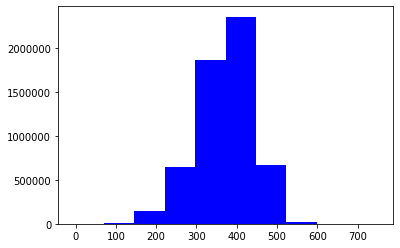

In [32]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Function to plot a histogram using pyplot
def create_hist(rdd_histogram_data):
  """Given an RDD.histogram, plot a pyplot histogram"""
  heights = np.array(rdd_histogram_data[1])
  full_bins = rdd_histogram_data[0]
  mid_point_bins = full_bins[:-1]
  widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
  bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
  return bar

# Compute a histogram of departure delays
departure_delay_histogram = mph\
  .select("Mph")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

create_hist(departure_delay_histogram)

## Iterating on a Histogram

That looks interesting, but the bars seem to fat the really see what is going on. Lets double the number of buckets from 10 to 20. We can reuse the `create_hist()` method to do so.

<BarContainer object of 20 artists>

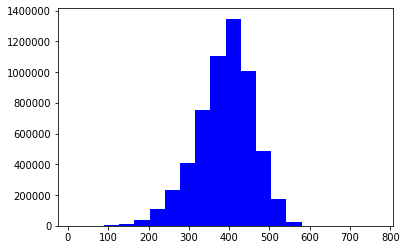

In [33]:
# Compute a histogram of departure delays
departure_delay_histogram = mph\
  .select("Mph")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(20)

create_hist(departure_delay_histogram)

## Speed Summary

You've now seen how to calculate different values in both SQL and Dataflow style, how to switch between the two methods, how to switch between the `pyspark.RDD` and `pyspark.sql.DataFrame` APIs and you're starting to build a proficiency in PySpark!

# Counting Airplanes in the US Fleet

Lets convert our `on_time_dataframe` (a `DataFrame`) into an `RDD` to calculate the total number of airplanes in the US fleet.

In [34]:
# Dump the unneeded fields
tail_numbers = on_time_dataframe.rdd.map(lambda x: x.TailNum)
tail_numbers = tail_numbers.filter(lambda x: x != '' and x is not None)

# distinct() gets us unique tail numbers
unique_tail_numbers = tail_numbers.distinct()

# now we need a count() of unique tail numbers
airplane_count = unique_tail_numbers.count()
print("Total airplanes: {}".format(airplane_count))

Total airplanes: 4897


# Exercise 1: Characterizing Airports

Using the techniques we demonstated above, calculate any 3 out of 4 of the following things using both the SQL and the Dataflow methods for each one. That is: implement each calculation twice - once in SQL and once using Dataflows. Try to use both the `RDD` and `DataFrame` APIs as you work.

1. How many airports are there in the united states?
2. What is the average flight time for flights arriving in San Francisco (SFO)? What does the distribution of this value look like? Plot a histogram using the `create_hist` method shown above.
3. Which American airport has the fastest out-bound speeds? What does the distribution of the flight speeds at this one airport look like? Plot a histogram using the `create_hist` method shown above.
4. What were the worst travel dates in terms of overall delayed flights in the US in 2015?

In [35]:
origin_hour_dist = on_time_dataframe.filter(
    on_time_dataframe.AirTime.isNotNull()
).select(
    "Origin", 
    (on_time_dataframe.AirTime/60).alias("Hours"), 
    "Distance"
)
mph_origins = origin_hour_dist.select(
    "Origin", 
    (origin_hour_dist.Distance / origin_hour_dist.Hours).alias("Mph")
)
mph_origins.registerTempTable("mph_origins")

avg_speeds = mph_origins.groupBy("Origin").agg({"Mph": "avg"}).alias("Mph")
avg_speeds.show()

+------+------------------+
|Origin|          avg(Mph)|
+------+------------------+
|   BGM| 346.1853538898441|
|   PSE| 452.6117680000053|
|   INL|286.26851316932107|
|   DLG|395.85893026325215|
|   MSY| 417.8806617127785|
|   PPG| 504.2422916767315|
|   GEG|  402.285589290541|
|   SNA| 417.1687699400066|
|   BUR|381.54113589717645|
|   GRB| 304.8341806425415|
|   GTF| 425.3390308053375|
|   IDA|352.21033421102914|
|   GRR| 345.7402330340281|
|   JLN|333.89806917791054|
|   PSG| 218.6399366568302|
|   EUG|408.36973646170964|
|   PVD|  377.284933612292|
|   GSO| 363.1599876379004|
|   MYR|392.41545245530034|
|   OAK| 411.1720814918298|
+------+------------------+
only showing top 20 rows



In [ ]:
on_time_dataframe.columns

## Calculating with `DataFrame.groupBy`

We can use Spark SQL to calculate things using `DataFrames`, but we can also group data and calculate as we did with `RDDs`. For a full list of methods you can apply to grouped `DataFrames`, see [the documentation for pyspark.sql.GroupedData](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.GroupedData). Below we will demonstrate some of these methods.

In [36]:
# Calculate average of every numeric field
on_time_dataframe.groupBy("Origin").avg().show(1)

# Calculate verage AirTime per origin city
on_time_dataframe.groupBy("Origin").agg({"AirTime": "mean"}).show(1)

# Get the count of flights from each origin
on_time_dataframe.groupBy("Origin").count().show(1)

# Get the maximum airtime for flights leaving each city
on_time_dataframe.groupby("Origin").agg({"AirTime": "max"}).show(1)

# Get the maximum of all numeric columns for flights leaving each city
on_time_dataframe.groupBy("Origin").max().show(1)

# Get the shortest flight for each origin airport
on_time_dataframe.groupBy("Origin").agg({"AirTime": "min"}).show(1)

# Total minutes flown from each airport
on_time_dataframe.groupBy("Origin").agg({"AirTime": "sum"}).show(1)

+------+----------------+--------------------+------------------+---------------+-----------------+--------------------+--------------------+-------------+----------------------+-----------------+------------+-------------+-----------------+-----------------+------------------+--------------------+----------------------+
|Origin|   avg(DepDelay)|avg(DepDelayMinutes)|      avg(TaxiOut)|    avg(TaxiIn)|    avg(ArrDelay)|avg(ArrDelayMinutes)|      avg(Cancelled)|avg(Diverted)|avg(ActualElapsedTime)|     avg(AirTime)|avg(Flights)|avg(Distance)|avg(CarrierDelay)|avg(WeatherDelay)|     avg(NASDelay)|  avg(SecurityDelay)|avg(LateAircraftDelay)|
+------+----------------+--------------------+------------------+---------------+-----------------+--------------------+--------------------+-------------+----------------------+-----------------+------------+-------------+-----------------+-----------------+------------------+--------------------+----------------------+
|   BGM|9.42056074766355|  15.1

### Pivoting DataFrames

One useful function of `DataFrames` is `pivot`. Pivot lets you compute pivot tables from data. Lets use `pivot` to calculate the average flight times between Atlanta `ATL` and other airports.

In [37]:
on_time_dataframe\
    .filter("Origin == 'ATL'")\
    .groupBy("Origin")\
    .pivot("Dest")\
    .avg("AirTime")\
    .rdd\
    .map(lambda x: x.asDict())\
    .collect()[0]

{'Origin': 'ATL',
 'ABE': 96.59897959183674,
 'ABQ': 172.1290684624018,
 'ABY': 29.252365930599368,
 'ACY': 90.23557692307692,
 'AEX': 78.87462235649546,
 'AGS': 29.076743280093496,
 'ALB': 108.65161923454367,
 'ANC': 426.3529411764706,
 'ASE': 198.09574468085106,
 'ATW': 105.11235955056179,
 'AUS': 117.13764946048411,
 'AVL': 33.510327455919395,
 'AVP': 93.94900849858357,
 'AZO': 86.6842105263158,
 'BDL': 109.44785031847134,
 'BHM': 28.848588537211292,
 'BMI': 78.14963119072708,
 'BNA': 38.880419382261266,
 'BOS': 120.84425582313462,
 'BQK': 41.63483735571878,
 'BTR': 70.18819188191883,
 'BTV': 119.43465045592706,
 'BUF': 93.706432748538,
 'BWI': 81.02321908071394,
 'BZN': 220.15625,
 'CAE': 33.79744210162461,
 'CAK': 72.89645776566758,
 'CHA': 24.022727272727273,
 'CHO': 66.9613478691774,
 'CHS': 42.49556255367879,
 'CID': 101.25268817204301,
 'CLE': 77.47449470644851,
 'CLT': 41.581799591002046,
 'CMH': 66.05350605463249,
 'COS': 161.14626865671642,
 'CRW': 57.365990202939116,
 'CSG

# Plotting Scatterplots

Another type of visualization that is of interest to data scientists is the scatterplot. A scatterplot enables us to compare the trend of one value plotted against the other. For example, we could calculate the relationship between `Origin` and `Dest` `Distance` and the `Mph` speed figure we calculated earlier. Are longer flights generally faster, or not?

To prepare a scatterplot, we need to use `matplotlib` again, so we'll need to look at what its scatterplot API expects. The `matplotlib.pyplot.scatter` API takes two independant lists of values for the variables x and y, so we must compute them for `Distance` and `Mph`.

In [38]:
mph = spark.sql("""
SELECT 
    Distance, 
    ( Distance / ( AirTime/60 ) ) AS Mph 
FROM on_time_performance 
WHERE AirTime IS NOT NULL
""")
mph.show(10)

+--------+------------------+
|Distance|               Mph|
+--------+------------------+
|   432.0| 439.3220338983051|
|   432.0| 336.6233766233766|
|   802.0| 373.0232558139535|
|   731.0|471.61290322580646|
|   769.0| 415.6756756756757|
|   769.0|427.22222222222223|
|  1047.0| 430.2739726027398|
|   731.0| 359.5081967213115|
|   731.0|466.59574468085106|
|   731.0|  481.978021978022|
+--------+------------------+
only showing top 10 rows



### Collecting Data

Note that we will have to convert our data from existing within our Spark cluster's memory to within our local computer's memory where `matplotlib` runs.

In [39]:
distance = mph.select("Distance").rdd.flatMap(lambda x: x)
distance = distance.collect()
distance[0:10]

[432.0, 432.0, 802.0, 731.0, 769.0, 769.0, 1047.0, 731.0, 731.0, 731.0]

In [40]:
speed = mph.select("Mph").rdd.flatMap(lambda x: x)
speed = speed.collect()
speed[0:10]

[439.3220338983051,
 336.6233766233766,
 373.0232558139535,
 471.61290322580646,
 415.6756756756757,
 427.22222222222223,
 430.2739726027398,
 359.5081967213115,
 466.59574468085106,
 481.978021978022]

## Sampling Data

When I tried to plot this data, it took a very long time to draw. This is because... well, how many unique values are there for each variable? Lets see.

In [41]:
print("Total distances: {:,}".format(len(distance)))
print("Total speeds: {:,}".format(len(speed)))

Total distances: 5,714,008
Total speeds: 5,714,008


It is hard to plot 5.7 million dots on a scatterplot that will fit on a computer screen. So lets sample our data. We can use PySpark `DataFrame's` sample method. Lets take a 0.1% random sample without replacement, which will leave us with 5,687 or so data points - something we can more easily manage.

In [42]:
sample = mph.sample(False, 0.001)
sample.count()

5865

Note that we need to sample __once__ and then split the datasets out - otherwise the data for a single observation will be scrambled across variables. We don't want that! All our scatterplots would show no relationships at all.

In [43]:
speed = sample.select("Mph").rdd.flatMap(lambda x: x).collect()
distance = sample.select("Distance").rdd.flatMap(lambda x: x).collect()
print("{:,} x {:,} records!".format(
    len(speed),
    len(distance)
))

5,865 x 5,865 records!


### Fun with `matplotlib.pyplot.scatter`

Now we feed the `scatter` API `distance` as `x` and `speed` as `y`, giving it a title and x and y axes. Note that we also specify a size in inches via the `figure.figsize` `rcParam`.

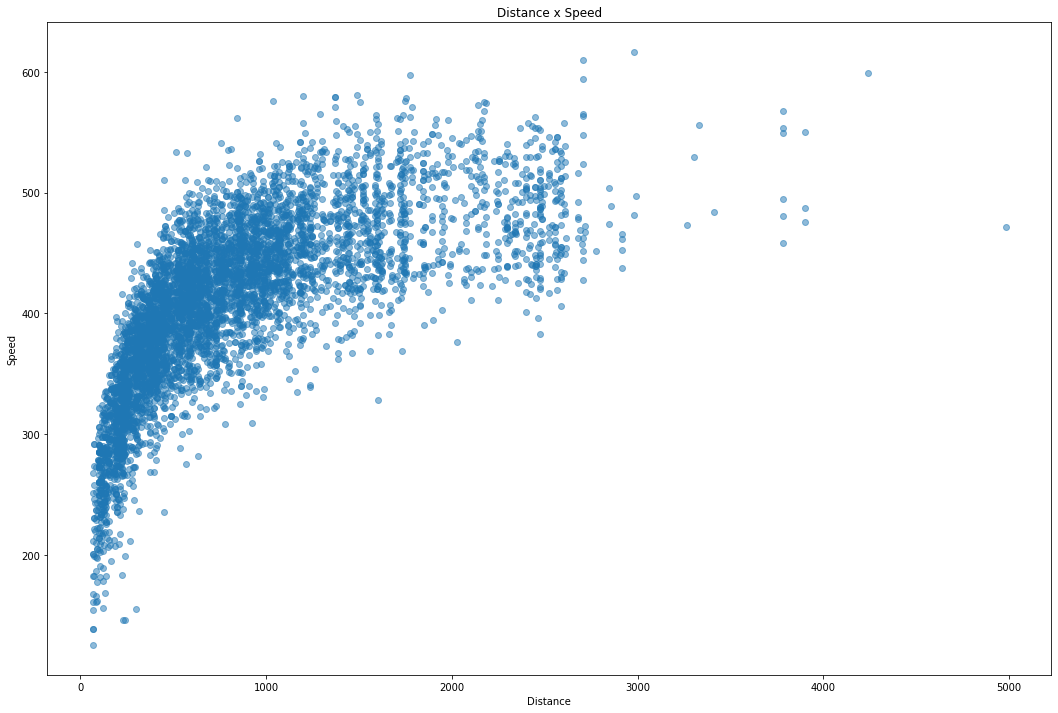

In [44]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (18,12)

plt.scatter(
    distance, 
    speed, 
    alpha=0.5
)
plt.title("Distance x Speed")
plt.xlabel("Distance")
plt.ylabel("Speed")
plt.show()

### Interpreting Our Scatterplot

We can see pretty clearly that as distance increases, average speed across that distance increases rapidly and then levels off as the distance increases.

## Exercises

1. Query the `on_time_dataframe` to focus on two numeric fields. 
2. Plot a histogram of one of these fields
3. Plot a scatterplot of both of these fields

# Predicting Speed Given Distance

It is often the case that once we characterize a distribution, we want to create a function to predict one variable given the other. Lets take this example further by fitting a polynomial regression to describe our data. We use `sklearn.pipeline.Pipeline` to chain a `sklearn.preprocessing.PolynomialFeatures` to a `sklearn.linear_model.LinearRegression`. Other than that, we simply define x and y, and fit a model to those values. Then we finally compute a cross value score, to see the model's performance. We'll see this pattern again when we use large data tools in Spark MLlib.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

x = np.array(distance)
y = np.array(speed)
x_test = np.arange(0, 5000, 100)

model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression(fit_intercept=False))
])
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_
y_out = model.predict(x_test.reshape(-1,1))

cross_val_score(model, x.reshape(-1,1), y)

/home/vagrant/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.62454561, 0.70210257, 0.6544795 ])

## Visualizing Polynomial Fit

Because we are running a polynomial regression, where we get to decide the degree of the polynomial. To help decide, lets plot a polynomial fit line to the data using `matplotlib`.

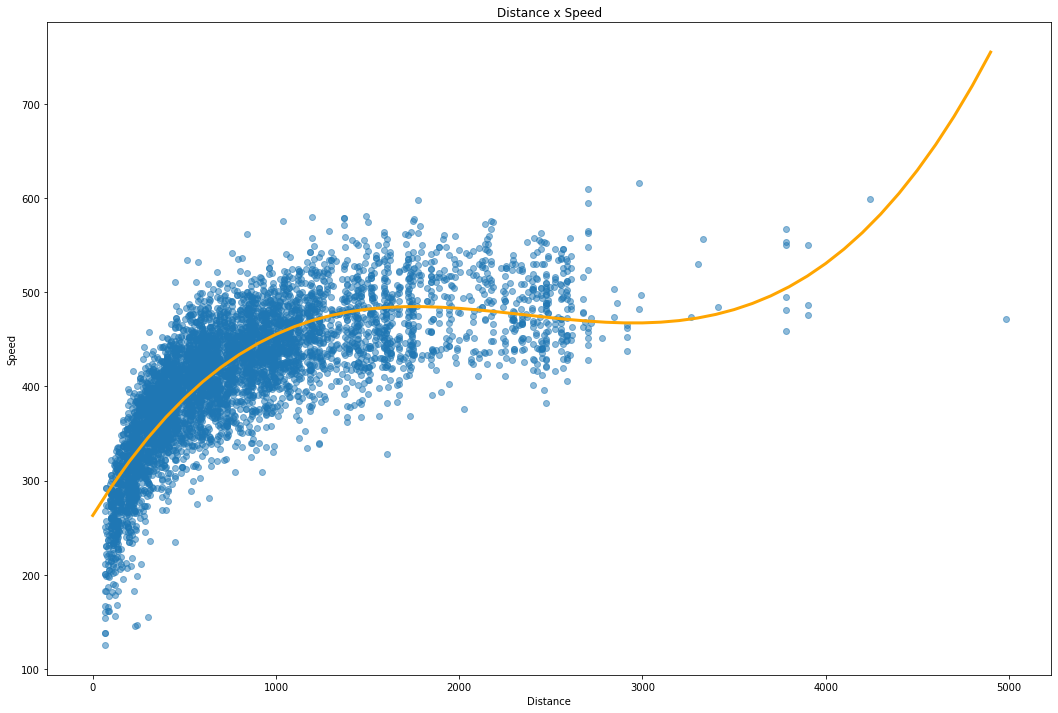

In [46]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (18,12)

plt.scatter(
    distance, 
    speed, 
    alpha=0.5
)
plt.plot(
    x_test,
    y_out, 
    color='orange', 
    linewidth=3
)

plt.title("Distance x Speed")
plt.xlabel("Distance")
plt.ylabel("Speed")
plt.show()

# Joining Data in PySpark

Next we're going to learn how to join between datasets using PySpark. We're going to pick up from an example we're going to work in chapter 6, and explore it more deeply. To begin with, we will prepare a list of `TailNum` (tail numbers) from the FAA flight records. These uniquely identify each airplane from each flight.

### Unique Tail Numbers

In [47]:
tail_numbers = on_time_dataframe.select("TailNum").distinct()
tail_numbers.show(6)

+-------+
|TailNum|
+-------+
| N396AA|
| N3CWAA|
| N499AA|
| N4YUAA|
| N567AA|
| N442AS|
+-------+
only showing top 6 rows



### FAA Airplane Records

We will trim the FAA records down to just the `TailNum`, `Model` and `Engine_Model`. Note that we go ahead and rename the `TailNum` field to `FAATailNum` using the `pyspark.sql.functions.alias()` method. This avoids having two fields referenced by the same name once we perform our joins.

In [48]:
faa_tail_number_inquiry = spark.read.json('../data/faa_tail_number_inquiry.jsonl')
airplane_records = faa_tail_number_inquiry.select(
    faa_tail_number_inquiry.TailNum.alias("FAATailNum"), 
    "Model",
    "Engine_Model"
)
airplane_records.show(6)

+----------+-----------+------------+
|FAATailNum|      Model|Engine_Model|
+----------+-----------+------------+
|    N933EV|CL-600-2B19| CF34 SERIES|
|    N917WN|    737-7H4|  CFM56-7B24|
|    N438WN|    737-7H4|CFM56 SERIES|
|    N283VA|   A320-214| CFM56-5B4/3|
|    N473UA|   A320-232| AL-25SERIES|
|    N637JB|   A320-232|    V2527-A5|
+----------+-----------+------------+
only showing top 6 rows



## Inner Joins

You may be familiar with an inner join from SQL. An inner join joins two datasets based on the presence of a key from one dataset in the other. Records which don't have a key that appears in the other table do not appear in the final output.

In [49]:
# INNER JOIN
print(
    "FAA tail numbers: {:,}".format(
        tail_numbers.count()
    )
)
print(
    "Airplane records: {:,}".format(
        airplane_records.count()
    )
)

inner_joined = tail_numbers.join(
    airplane_records, 
    tail_numbers.TailNum == airplane_records.FAATailNum, 
    'inner'
)

print(
    "Joined records:   {:,}".format(
        inner_joined.count()
    )
)

FAA tail numbers: 4,898
Airplane records: 3,988
Joined records:   3,988


### Inner Join Results

Note that there are as many records in the output as there were in the FAA Airplane dataset - indicating that there was a representative of every tail number from that dataset in the on-time performance flight records. Lets take a look at the records themselves.

In [50]:
inner_joined.show(6)

+-------+----------+--------------+------------+
|TailNum|FAATailNum|         Model|Engine_Model|
+-------+----------+--------------+------------+
| N396AA|    N396AA|          B300|    PT6A SER|
| N499AA|    N499AA|DC-9-82(MD-82)| JT8D SERIES|
| N442AS|    N442AS|     737-990ER| CFM56-7B27E|
| N369NB|    N369NB|      A319-114|CFM56 SERIES|
| N388DA|    N388DA|       737-832|CFM56 SERIES|
|  N6700|     N6700|       757-232|      PW2037|
+-------+----------+--------------+------------+
only showing top 6 rows



Note how convenient it is that we renamed one of the keys `FAATailNum`. If we hadn't, we'd have two columns with the same name now and would have trouble referring to one or the other.

## Left Outer Join

Another type of join is the left outer join. It ensures that one record will remain in the output from the left side of the join no matter what. If a match on the join keys is found, the fields for the record on the right will be filled. If a match is not found, they will be empty. 

Lets look at how this works with our two datasets.

In [51]:
# INNER JOIN
print(
    "FAA tail numbers: {:,}".format(
        tail_numbers.count()
    )
)
print(
    "Airplane records: {:,}".format(
        airplane_records.count()
    )
)

left_outer_joined = tail_numbers.join(
    airplane_records, 
    tail_numbers.TailNum == airplane_records.FAATailNum, 
    'left_outer'
)

print(
    "Joined records:   {:,}".format(
        left_outer_joined.count()
    )
)

FAA tail numbers: 4,898
Airplane records: 3,988
Joined records:   4,898


## Left Outer Join Result

Note that there were 4,898 records on the left side of our join and there are the same number on the output of our join. Lets take a look at what both matched and unmatched records look like:

In [52]:
left_outer_joined.show(6)

+-------+----------+--------------+------------+
|TailNum|FAATailNum|         Model|Engine_Model|
+-------+----------+--------------+------------+
| N396AA|    N396AA|          B300|    PT6A SER|
| N3CWAA|      null|          null|        null|
| N499AA|    N499AA|DC-9-82(MD-82)| JT8D SERIES|
| N4YUAA|      null|          null|        null|
| N567AA|      null|          null|        null|
| N442AS|    N442AS|     737-990ER| CFM56-7B27E|
+-------+----------+--------------+------------+
only showing top 6 rows



Note that some records have fields filled out, and some don't.

## Right Outer Join

Another type of join is the right outer join. This works the opposite of a left outer join. In this case, the output will preserve a record for each and every record on the right side of the join. Use the `right_outer` join type to perform this kind of join.

## Exercises

1. Go back and perform a right outer join on the preceding two datasets. Is the `distinct()` call on the FAA on-time performance records still needed? Why or why not?


# Using `RDDs` and Map/Reduce to Prepare a Complex Record

In [53]:
# Filter down to the fields we need to identify and link to a flight
flights = on_time_dataframe.rdd.map(
    lambda x: (x.Carrier, x.FlightDate, x.FlightNum, x.Origin, x.Dest, x.TailNum)
)

# Group flights by tail number, sorted by date, then flight number, then origin/dest
flights_per_airplane = flights\
  .map(lambda nameTuple: (nameTuple[5], [nameTuple[0:5]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'TailNum': tuple[0], 
        'Flights': sorted(tuple[1], key=lambda x: (x[1], x[2], x[3], x[4]))
      }
    )
flights_per_airplane.first()

{'TailNum': 'N382DA',
 'Flights': [('DL', '2015-01-02', '1664', 'MSP', 'DCA'),
  ('DL', '2015-01-02', '1968', 'LAX', 'MSP'),
  ('DL', '2015-01-03', '1303', 'SLC', 'BOS'),
  ('DL', '2015-01-03', '1374', 'OAK', 'SLC'),
  ('DL', '2015-01-03', '1374', 'SLC', 'OAK'),
  ('DL', '2015-01-03', '1944', 'DCA', 'SLC'),
  ('DL', '2015-01-03', '2071', 'SLC', 'PHX'),
  ('DL', '2015-01-03', '966', 'PHX', 'SLC'),
  ('DL', '2015-01-04', '1207', 'DTW', 'SLC'),
  ('DL', '2015-01-04', '2079', 'BOS', 'DTW'),
  ('DL', '2015-01-05', '2324', 'SLC', 'ATL'),
  ('DL', '2015-01-05', '2352', 'ATL', 'JFK'),
  ('DL', '2015-01-06', '332', 'SJU', 'JFK'),
  ('DL', '2015-01-06', '425', 'JFK', 'SJU'),
  ('DL', '2015-01-08', '421', 'JFK', 'ATL'),
  ('DL', '2015-01-10', '2264', 'LAX', 'MEM'),
  ('DL', '2015-01-11', '2020', 'MEM', 'LAX'),
  ('DL', '2015-01-11', '2534', 'LAX', 'BOS'),
  ('DL', '2015-01-11', '2549', 'BOS', 'MSP'),
  ('DL', '2015-01-12', '2193', 'MSP', 'SEA'),
  ('DL', '2015-01-12', '2424', 'SEA', 'DTW'),
  ('D

# Counting Late Flights

In [56]:
total_flights = on_time_dataframe.count()

# Flights that were late leaving...
late_departures = on_time_dataframe.filter(
  on_time_dataframe.DepDelayMinutes > 0
)
total_late_departures = late_departures.count()
print(f'{total_late_departures:,}')

# Flights that were late arriving...
late_arrivals = on_time_dataframe.filter(
  on_time_dataframe.ArrDelayMinutes > 0
)
total_late_arrivals = late_arrivals.count()
print(f'{total_late_arrivals:,}')

# Get the percentage of flights that are late, rounded to 1 decimal place
pct_late = round((total_late_arrivals / (total_flights * 1.0)) * 100, 1)
pct_late

2,125,618
2,086,896


35.9

# Counting Flights with Hero Captains

"Hero Captains" are those that depart late but make up time in the air and arrive on time or early.

In [60]:
# Flights that left late but made up time to arrive on time...
on_time_heros = on_time_dataframe.filter(
  (on_time_dataframe.DepDelayMinutes > 0)
  &
  (on_time_dataframe.ArrDelayMinutes <= 0)
)
total_on_time_heros = on_time_heros.count()
print(f'{total_on_time_heros:,}')

606,902


# Printing Our Results

In [61]:
print("Total flights:   {:,}".format(total_flights))
print("Late departures: {:,}".format(total_late_departures))
print("Late arrivals:   {:,}".format(total_late_arrivals))
print("Recoveries:      {:,}".format(total_on_time_heros))
print("Percentage Late: {}%".format(pct_late))

Total flights:   5,819,079
Late departures: 2,125,618
Late arrivals:   2,086,896
Recoveries:      606,902
Percentage Late: 35.9%


# Computing the Average Lateness Per Flights

In [62]:
# Get the average minutes late departing and arriving
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
"""
).show()

+-----------+-----------+
|AvgDepDelay|AvgArrDelay|
+-----------+-----------+
|        9.4|        4.4|
+-----------+-----------+



# Inspecting Late Flights

In [63]:
# Why are flights late? Lets look at some delayed flights and the delay causes
late_flights = spark.sql("""
SELECT
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")
late_flights.sample(False, 0.01).show()

+---------------+------------+------------+--------+-------------+-----------------+
|ArrDelayMinutes|WeatherDelay|CarrierDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------------+------------+------------+--------+-------------+-----------------+
|           31.0|         0.0|        31.0|     0.0|          0.0|              0.0|
|           61.0|         0.0|         0.0|     0.0|          0.0|             61.0|
|           17.0|         0.0|         0.0|    17.0|          0.0|              0.0|
|          310.0|         0.0|        75.0|     0.0|          0.0|            235.0|
|           17.0|         0.0|         0.0|     2.0|          0.0|             15.0|
|           56.0|         0.0|        30.0|     0.0|          0.0|             26.0|
|           17.0|         0.0|        14.0|     3.0|          0.0|              0.0|
|          126.0|         0.0|         0.0|    21.0|          0.0|            105.0|
|           29.0|         0.0|         0.0|     2.0|          0.0

# Determining Why Flights Are Late

In [64]:
# Calculate the percentage contribution to delay for each source
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

+-----------------+-----------------+-------------+------------------+-----------------------+
|pct_weather_delay|pct_carrier_delay|pct_nas_delay|pct_security_delay|pct_late_aircraft_delay|
+-----------------+-----------------+-------------+------------------+-----------------------+
|              4.5|             29.2|         20.7|               0.1|                   36.1|
+-----------------+-----------------+-------------+------------------+-----------------------+



# Computing a Histogram of Weather Delayed Flights

In [67]:
# Eyeball the first to define our buckets
weather_delay_histogram = on_time_dataframe\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 1440.0], [5436, 7668, 6636, 16007, 13569, 9442, 4598, 1136, 152, 72])


<BarContainer object of 10 artists>

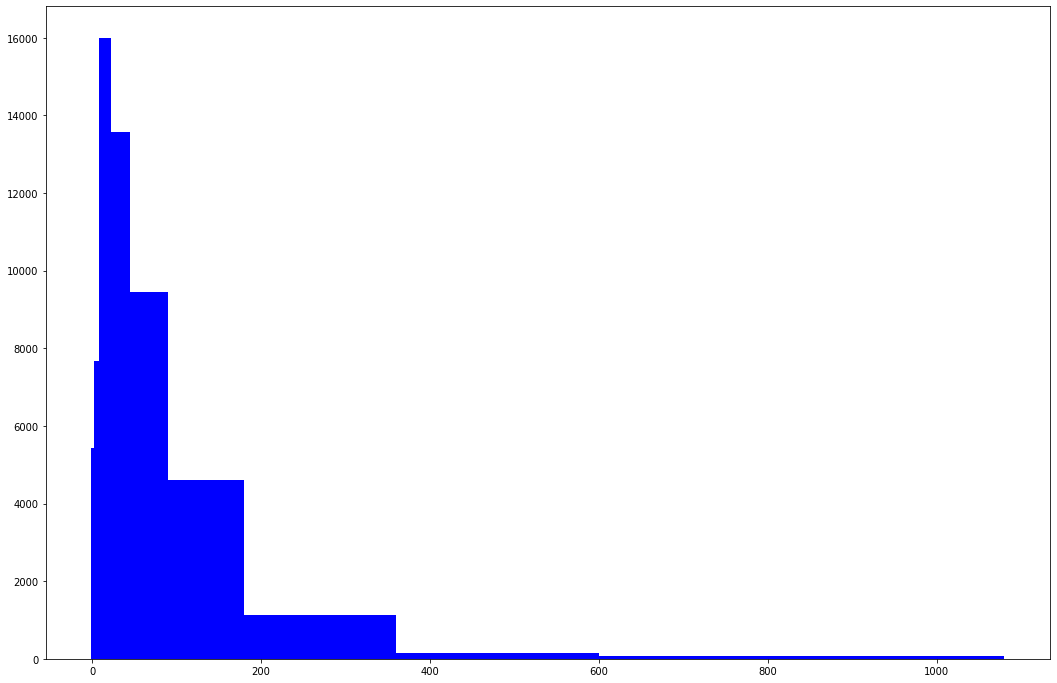

In [69]:
# See above for definition
create_hist(weather_delay_histogram)

# Preparing a Histogram for Visualization by d3.js

In [73]:
# Transform the data into something easily consumed by d3
def histogram_to_publishable(histogram):
  record = {'key': 1, 'data': []}
  for label, value in zip(histogram[0], histogram[1]):
    record['data'].append(
      {
        'label': label,
        'value': value
      }
    )
  return record

# Recompute the weather histogram with a filter for on-time flights
weather_delay_histogram = on_time_dataframe\
  .filter(
    (on_time_dataframe.WeatherDelay.isNotNull())
    &
    (on_time_dataframe.WeatherDelay > 0)
  )\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([0, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

record = histogram_to_publishable(weather_delay_histogram)
record

([0, 15, 30, 60, 120, 240, 480, 720, 1440.0], [19740, 16007, 13569, 9442, 4598, 1136, 152, 72])


{'key': 1,
 'data': [{'label': 0, 'value': 19740},
  {'label': 15, 'value': 16007},
  {'label': 30, 'value': 13569},
  {'label': 60, 'value': 9442},
  {'label': 120, 'value': 4598},
  {'label': 240, 'value': 1136},
  {'label': 480, 'value': 152},
  {'label': 720, 'value': 72}]}

# Building a Classifier Model to Predict Flight Delays

## Loading Our Data

In [74]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.jsonl.bz2",
  schema=schema
)
features.first()

Row(ArrDelay=13.0, CRSArrTime=datetime.datetime(2015, 1, 1, 18, 10), CRSDepTime=datetime.datetime(2015, 1, 1, 15, 30), Carrier='AA', DayOfMonth=1, DayOfWeek=4, DayOfYear=1, DepDelay=14.0, Dest='DFW', Distance=569.0, FlightDate=datetime.date(2014, 12, 31), FlightNum='1024', Origin='ABQ')

## Check Data for Nulls

In [75]:
#
# Check for nulls in features before using Spark ML
#
null_counts = [(column, features.where(features[column].isNull()).count()) for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

[]


## Add a Route Column

Demonstrating the addition of a feature to our model...

In [76]:
#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat

features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

+------+----+-------+
|Origin|Dest|  Route|
+------+----+-------+
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
+------+----+-------+
only showing top 5 rows



## Bucketizing ArrDelay into ArrDelayBucket

In [77]:
#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show()

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|           2.0|
|     1.0|           2.0|
|   -29.0|           0.0|
|   -10.0|           1.0|
|    -3.0|           1.0|
|    -8.0|           1.0|
|    -1.0|           1.0|
|   -14.0|           1.0|
|   -16.0|           0.0|
|    18.0|           2.0|
+--------+--------------+
only showing top 20 rows



## Indexing Our String Fields into Numeric Fields

In [78]:
#
# Extract features tools in with pyspark.ml.feature
#
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Turn category fields into categoric feature vectors, then drop intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                          .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|    13.0|2015-01-01 18:10:00|2015-01-01 15:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|          2.0|            25.0|            0.0| 

## Combining Numeric Fields into a Single Vector

In [79]:
# Handle continuous, numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show()

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|    13.0|2015-01-01 18:10:00|2015-01-01 15:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,2.0,2...|
|    17.0|2015-01-01 10:15:00|2015-01-01 07:25:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,2.0,2...|
|    36.0|2015-01-01 11:45:00|2015-01-01 09:00:00|     AA|         1|      

## Training Our Model in an Experimental Setup

In [80]:
#
# Cross validate, train and evaluate classifier
#

# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.7, 0.3])

# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024
)
model = rfc.fit(training_data)

# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="ArrDelayBucket", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

# Check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

Accuracy = 0.5967731197652838
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|   -10.0|2015-01-02 08:35:00|2015-01-02 07:30:00|     WN|         2|        5|        2|    -4.0| LAX|   236.0|2015-01-01|     2169|   LAS|LAS-LAX|           1.0|[-4.0,236.0,0.0,5...|[4.69368614250692...|[0.23468430712534...|       1.0|
|   200.0|2015-01-